<div style="text-align:center; font-size:40px; font-weight:bold;">SHAPE DETECTION</div>

## Problem statement and methodology

**Project Objective:** The aim of our project is to develop a model capable of differentiating between various geometric shapes using a topological data analysis approach.<br>
<br>
**Data Preparation:** In the m_create_pointclouds.py script, we generated 160 point clouds representing 8 distinct shapes, ensuring 20 point clouds per shape. The shapes we focused on include spheres, circles, line segments, tori, flat discs, ellipsoids, perturbed 3-discs and rectangles. We introduced a degree of randomness to these shapes, altering the positions of their constituent points to simulate natural variations.<br>
<br>
**Methodology:**<br>
<br>
1\)**Standardization:** Our first step involves standardizing the data. We achieve this by confining each shape within a uniformly sized box. Simultaneously, we translate each shape to align its center with the origin (0,0,0). This process ensures that all shapes are comparable in size and positioning.<br>
<br>
2\)**Topological Analysis:**<br>
    Building Rips Complexes: We initiate the analysis by expanding spheres (or balls) around each point in the point clouds, progressively increasing their radii. This method allows us to construct a sequence of Rips complexes.
    Persistence Diagrams: From these Rips complexes, we compute persistence diagrams. These diagrams capture the essential topological features of each shape, highlighting their birth and death within the evolving complex.<br>
<br>
3\)**Vectorization of Topological Data:**<br>
    We transform these persistence diagrams into a numerical format suitable for machine learning models. For this, we use persistence images, a technique that effectively vectorizes the topological data.
    To enhance the distinction between shapes that might have similar persistence diagrams (like a line and a rectangle), we create a modified set of shapes. We do this by removing a small open ball from the center of each original shape and recalculating their persistence diagrams and images.
    We later found out that we get the best results if we do this twice: one time we remove bigger ball and one time smaller.<br>
<br>
4\)**Data Integration and Model Training:**<br>
    We combine the vectorized data from both the original and modified shapes, creating a feature set for each point cloud.
    Following a train-test split, we employ a Support Vector Machine (SVM) model for classification. The model is optimized and then evaluated on the test set to assess its performance in distinguishing between the various shapes.


# Building datasets for our model

File **m_create_pointclouds.py** includes functions for generation of pointcloud representatations of 8 distinct shapes. We generated 20 instances of each shape and saved them in m_shapes_data.pkl.<br>
File **standardize.py** includes function for standardization of a pointcloud. Function confines each shape within a uniformly sized box and translates each shape to align its center with the origin (0,0,0). We applied this function to our pointclouds and saved the output in scaled_centered_shapes_data.pkl.<br>
File **remove_ball.py** includes function that removes a ball with specified radius from the origin (which is now also a center of standardized pointclouds). We use this function on standardized pointclouds and save the output in modified_shape_data.pkl.<br>
File **create_PD_and_PI.py** includes function for calculating persistence diagrams and images of pointclouds. We apply it to our original standardized shapes and standardized shapes without a ball of points. We save the outputs in flattened_images_with_indices.pkl and flattened_images_removed_ball_with_indices.pkl and later combine them to combined_flattened_data_with_indices.pkl.

# Building our model

In [1]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

We first load the vectorized form of our shapes for SVM model and original shapes for visualization.

In [2]:
# Load the combined flattened images, labels
with open('Data/combined3_flattened_data_with_indices.pkl', 'rb') as f_img:
    combined_flattened_data = pickle.load(f_img)

# Extracting indices, combined vectors, and labels
indices, combined_vectors, labels = zip(*combined_flattened_data)

# Convert to numpy arrays
combined_vectors = np.array(combined_vectors)
labels = np.array(labels)

# Load the original point clouds for visualization
with open('Shape_data/m_shapes_data.pkl', 'rb') as file:
    original_shape_data = pickle.load(file)

# Extracting indices, combined vectors, and labels
indices2, combined_vectors2, labels2 = zip(*original_shape_data)

We make train test split with stratification.

In [3]:
# Train-test split with stratification
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    combined_vectors, labels, indices, test_size=0.3, random_state=42, stratify=labels
)

Now we train our SVM model. We will try different parameters and evaluate it with cross validation on training set.

In [4]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define the parameter grid: 
param_grid = {
    'C': [0.1, 1, 10, 100, 200],  # Regularization parameter
    'kernel': ['rbf']  # RBF kernel
}

# Initialize the SVM model
svm_model = SVC()

# Set up GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, cv=5, verbose=2, n_jobs=-1)

# Fit grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Retrieve the best model
svm_model = grid_search.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[CV] END ...................................C=10, kernel=rbf; total time=   1.4s
[CV] END ....................................C=1, kernel=rbf; total time=   1.7s
[CV] END ....................................C=1, kernel=rbf; total time=   1.8s
[CV] END ...................................C=10, kernel=rbf; total time=   1.4s
[CV] END ....................................C=1, kernel=rbf; total time=   1.8s
[CV] END ....................................C=1, kernel=rbf; total time=   1.9s
[CV] END ..................................C=0.1, kernel=rbf; total time=   2.3s
[CV] END ....................................C=1, kernel=rbf; total time=   2.4s
[CV] END ..................................C=0.1, kernel=rbf; total time=   2.7s
[CV] END ..................................C=0.1, kernel=rbf; total time=   2.7s
[CV] END ..................................C=0.1, kernel=rbf; total time=   2.9s
[CV] END ...................................C=10, kernel=rbf; total time=   1.3s
[CV] END ...................

### Functions for visualization and analyzation

Function for visualization of pointclouds.

In [5]:
def plot_point_cloud(point_cloud, ax, title="Point Cloud"):
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2])
    ax.set_title(title)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

Dictionary for decoding integers back to the shape name.

In [6]:
label_names = {0: "sphere", 1: "circle", 2: "line_segment", 3: "torus", 4: "flat_disc", 5: "ellipsoid", 6: "perturbed_3_disc",7:"rectangle"}

Function for visualization of some random test samples. Pointclouds are visualized and we also get printed statements which class does the shape belong to and to which class it was classified.

In [7]:
def visualize_n_samples(y_true, y_pred, shape_data, idx, num_samples_to_visualize=4):
    fig = plt.figure(figsize=(10, 8))

    for i in range(num_samples_to_visualize):
        # Get the original point cloud index from the test set
        original_index = idx[i]

        # Find the test point cloud using the index
        test_point_cloud = next((pc for idx, pc, _ in shape_data if idx == original_index), None)

        if test_point_cloud is not None:
            # Plot the point cloud
            ax = fig.add_subplot(2, num_samples_to_visualize, i + 1, projection='3d')
            plot_point_cloud(test_point_cloud, ax, title=f"Test Sample {i+1}")

            # Set the same scale for all axes
            max_range = np.array([test_point_cloud[:,0].max()-test_point_cloud[:,0].min(), 
                                test_point_cloud[:,1].max()-test_point_cloud[:,1].min(), 
                                test_point_cloud[:,2].max()-test_point_cloud[:,2].min()]).max() / 2.0
            mid_x = (test_point_cloud[:,0].max()+test_point_cloud[:,0].min()) * 0.5
            mid_y = (test_point_cloud[:,1].max()+test_point_cloud[:,1].min()) * 0.5
            mid_z = (test_point_cloud[:,2].max()+test_point_cloud[:,2].min()) * 0.5
            ax.set_xlim(mid_x - max_range, mid_x + max_range)
            ax.set_ylim(mid_y - max_range, mid_y + max_range)
            ax.set_zlim(mid_z - max_range, mid_z + max_range)

            # Print the prediction and actual label
            predicted_label = y_pred[i]
            actual_label = y_true[i]
            predicted_shape = label_names.get(predicted_label, "Unknown")
            actual_shape = label_names.get(actual_label, "Unknown")
            print(f"Test Sample {i+1} - Predicted Class: {predicted_shape}, Actual Class: {actual_shape}")
        else:
            print(f"Test Sample {i+1} - Original point cloud not found for index {original_index}")

    plt.tight_layout()
    plt.show()

Function for visualization of pointclouds for specified indices.

In [8]:
def visualize_samples(y_true, y_pred, shape_data, indices_to_visualize):
    fig = plt.figure(figsize=(10, 8))

    for i, original_index in enumerate(indices_to_visualize):
        # Find the test point cloud using the index
        test_point_cloud = next((pc for idx, pc, label in shape_data if idx == original_index), None)

        if test_point_cloud is not None:
            # Plot the point cloud
            ax = fig.add_subplot(1, len(indices_to_visualize), i + 1, projection='3d')
            plot_point_cloud(test_point_cloud, ax, title=f"Test Sample {original_index}")

            # Set the same scale for all axes
            max_range = np.array([test_point_cloud[:, 0].max()-test_point_cloud[:, 0].min(), 
                                  test_point_cloud[:, 1].max()-test_point_cloud[:, 1].min(), 
                                  test_point_cloud[:, 2].max()-test_point_cloud[:, 2].min()]).max() / 2.0
            mid_x = (test_point_cloud[:, 0].max()+test_point_cloud[:, 0].min()) * 0.5
            mid_y = (test_point_cloud[:, 1].max()+test_point_cloud[:, 1].min()) * 0.5
            mid_z = (test_point_cloud[:, 2].max()+test_point_cloud[:, 2].min()) * 0.5
            ax.set_xlim(mid_x - max_range, mid_x + max_range)
            ax.set_ylim(mid_y - max_range, mid_y + max_range)
            ax.set_zlim(mid_z - max_range, mid_z + max_range)

            # Get the true and predicted labels
            true_label = y_true[original_index]
            predicted_label = y_pred[original_index]
            true_shape = label_names.get(true_label, "Unknown")
            predicted_shape = label_names.get(predicted_label, "Unknown")
            print(f"Test Sample {original_index} - Predicted Class: {predicted_shape}, Actual Class: {true_shape}")
        else:
            print(f"Test Sample {original_index} - Original point cloud not found for index {original_index}")

    plt.tight_layout()
    plt.show()


Function for printing the number of correctly and incorrectly classified pointclouds for each class.

In [9]:
def classification_report(y_true, y_predicted):
    from sklearn.metrics import confusion_matrix
    import numpy as np

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_predicted)

    # Calculate and display class-wise accuracy
    for class_index, class_name in label_names.items():
        correct = conf_matrix[class_index, class_index]
        incorrect = sum(conf_matrix[class_index, :]) - correct
        print(f"Class '{class_name}': Correctly classified: {correct}, Incorrectly classified: {incorrect}")

Function that prints misclassified pointclouds. It prints the index of misclassified pointcloud, actual class and predicted class.

In [10]:
def analyze_misclassifications(y_true, y_pred, label_names):
    misclassified = []

    for i in range(len(y_true)):
        if y_true[i] != y_pred[i]:
            original_class = label_names.get(y_true[i], "Unknown")
            predicted_class = label_names.get(y_pred[i], "Unknown")
            misclassified.append((i, original_class, predicted_class))

    return misclassified

Function that creates an interactive plot (that we can rotate and further inspect) for given pointcloud set and index. It helps us to figure why some pointclouds were misclassified.

In [37]:
#%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
#import ipywidgets as widgets

def plot_interactive_point_cloud(index, shape_data):
    """
    Plots an interactive 3D point cloud for the given index from the shape data.

    Args:
    index (int): Index of the point cloud in the shape data.
    shape_data (list): List of tuples containing (index, point cloud, label).
    """
    point_cloud = next((pc for idx, pc, _ in shape_data if idx == index), None)

    if point_cloud is not None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2])
        
        # Setting the same scale for all axes
        max_range = np.array([point_cloud[:,0].max()-point_cloud[:,0].min(), 
                              point_cloud[:,1].max()-point_cloud[:,1].min(), 
                              point_cloud[:,2].max()-point_cloud[:,2].min()]).max() / 2.0
        mid_x = (point_cloud[:,0].max()+point_cloud[:,0].min()) * 0.5
        mid_y = (point_cloud[:,1].max()+point_cloud[:,1].min()) * 0.5
        mid_z = (point_cloud[:,2].max()+point_cloud[:,2].min()) * 0.5
        ax.set_xlim(mid_x - max_range, mid_x + max_range)
        ax.set_ylim(mid_y - max_range, mid_y + max_range)
        ax.set_zlim(mid_z - max_range, mid_z + max_range)

        ax.set_xlabel('X axis')
        ax.set_ylabel('Y axis')
        ax.set_zlabel('Z axis')
        plt.show()
    else:
        print("Index not found in the dataset")

### Analyzing predictions on test set

Now lets check the predictions on test set.

Accuracy: 1.00

Test Sample 1 - Predicted Class: circle, Actual Class: circle
Test Sample 2 - Predicted Class: flat_disc, Actual Class: flat_disc
Test Sample 3 - Predicted Class: flat_disc, Actual Class: flat_disc
Test Sample 4 - Predicted Class: perturbed_3_disc, Actual Class: perturbed_3_disc
Test Sample 5 - Predicted Class: line_segment, Actual Class: line_segment


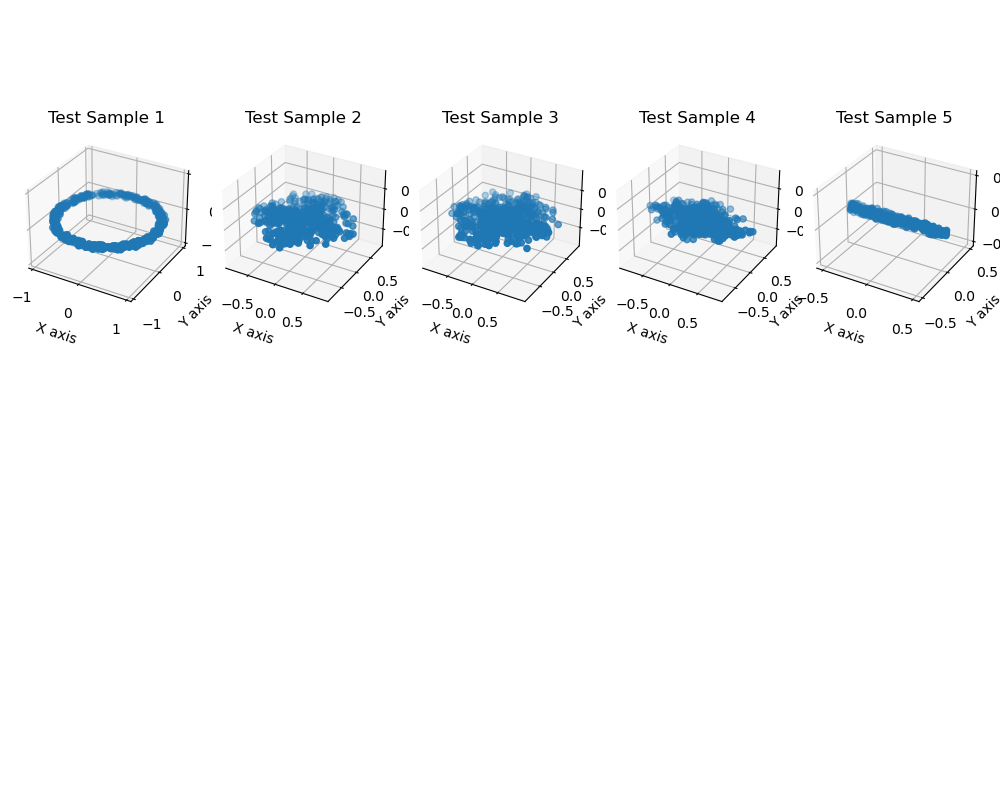

In [38]:
# Predict on the test set
y_pred = svm_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}\n")

visualize_n_samples(y_test,y_pred,original_shape_data,idx_test,5)


Now we check how many pointclouds belonging to each class did we classify correctly in test set. (We already know that the answer is all because the accuracy is 1)

In [39]:
classification_report(y_test,y_pred)

Class 'sphere': Correctly classified: 6, Incorrectly classified: 0
Class 'circle': Correctly classified: 6, Incorrectly classified: 0
Class 'line_segment': Correctly classified: 6, Incorrectly classified: 0
Class 'torus': Correctly classified: 6, Incorrectly classified: 0
Class 'flat_disc': Correctly classified: 6, Incorrectly classified: 0
Class 'ellipsoid': Correctly classified: 6, Incorrectly classified: 0
Class 'perturbed_3_disc': Correctly classified: 6, Incorrectly classified: 0
Class 'rectangle': Correctly classified: 6, Incorrectly classified: 0


Now we print misclassified test shapes. We already know there will not be any.

In [40]:
# Analyze misclassifications on the test set
misclassifications = analyze_misclassifications(y_test, y_pred, label_names)

# Print the misclassifications
print("Misclassified Shapes:")
for index, original_class, predicted_class in misclassifications:
    print(f"Index: {index}, Original Class: {original_class}, Predicted Class: {predicted_class}")


Misclassified Shapes:


Now we just quickly check how our model performed on training set.

### Analyzing predictions on training set

We can also check how our model is performing on training set.

In [41]:
# Predict on the training set
y_train_pred = svm_model.predict(X_train)

# Calculate accuracy
accuracy_train = accuracy_score(y_train, y_train_pred)
print(f"Accuracy: {accuracy_train:.2f}\n")

classification_report(y_train,y_train_pred)


Accuracy: 1.00

Class 'sphere': Correctly classified: 14, Incorrectly classified: 0
Class 'circle': Correctly classified: 14, Incorrectly classified: 0
Class 'line_segment': Correctly classified: 14, Incorrectly classified: 0
Class 'torus': Correctly classified: 14, Incorrectly classified: 0
Class 'flat_disc': Correctly classified: 14, Incorrectly classified: 0
Class 'ellipsoid': Correctly classified: 14, Incorrectly classified: 0
Class 'perturbed_3_disc': Correctly classified: 14, Incorrectly classified: 0
Class 'rectangle': Correctly classified: 14, Incorrectly classified: 0


Again everything is classified correctly.

The shapes we created for training and testing of this model were quite nice so the classification task was probably not too difficult. To further inspect the performance of our model we will now try to classify randomly translated and rotated pointclouds from the original dataset. (and at the end we will also inspect our model on rotated, translated and shapes with very distinct size from that of the training shapes)

## Translations and rotations

Now that we trained our model, we can test how well it is performing if we translate and rotate our original data. We randomly rotated and translated our original data and saved it in m_rotated_translated_shaped_data.pkl. Then we standardized it, removed balls, calculated PD and PI as before and saved vectorized features in TR_combined3_flattened_data_with_indices.pkl.<br>
Now we can check how our trained model is performing on this data.

In [42]:
with open('Data/TR_combined3_flattened_data_with_indices.pkl', 'rb') as f_img:
    TR_combined_flattened_data = pickle.load(f_img)

# Extracting indices, combined vectors, and labels
TR_indices, TR_combined_vectors, TR_labels = zip(*TR_combined_flattened_data)

# Convert to numpy arrays
TR_combined_vectors = np.array(TR_combined_vectors)
TR_labels = np.array(TR_labels)

# Load the rotated point clouds for visualization
with open('Shape_data/m_rotated_translated_shapes_data.pkl', 'rb') as file:
    TR_original_shape_data = pickle.load(file)

# Extracting indices, combined vectors, and labels
TR_indices2, TR_combined_vectors2, TR_labels2 = zip(*TR_original_shape_data)

In [43]:
TR_y_pred = svm_model.predict(TR_combined_vectors)

# Calculate accuracy
TR_accuracy = accuracy_score(TR_labels, TR_y_pred)
print(f"Accuracy: {TR_accuracy:.2f}")

Accuracy: 0.94


Accuracy is not 1 as before but still quite high. We now inspect misclassified shapes.

In [44]:
classification_report(TR_labels,TR_y_pred)

Class 'sphere': Correctly classified: 20, Incorrectly classified: 0
Class 'circle': Correctly classified: 20, Incorrectly classified: 0
Class 'line_segment': Correctly classified: 20, Incorrectly classified: 0
Class 'torus': Correctly classified: 20, Incorrectly classified: 0
Class 'flat_disc': Correctly classified: 19, Incorrectly classified: 1
Class 'ellipsoid': Correctly classified: 16, Incorrectly classified: 4
Class 'perturbed_3_disc': Correctly classified: 17, Incorrectly classified: 3
Class 'rectangle': Correctly classified: 19, Incorrectly classified: 1


In [45]:
# Analyze misclassifications on the training set
TR_misclassifications = analyze_misclassifications(TR_labels, TR_y_pred, label_names)#,TR_indices)

# Print the misclassifications
print("Misclassified Shapes in Training Set:")
for index, original_class, predicted_class in TR_misclassifications:
    print(f"Index: {index}, Original Class: {original_class}, Predicted Class: {predicted_class}")

Misclassified Shapes in Training Set:
Index: 95, Original Class: flat_disc, Predicted Class: rectangle
Index: 102, Original Class: ellipsoid, Predicted Class: sphere
Index: 105, Original Class: ellipsoid, Predicted Class: sphere
Index: 114, Original Class: ellipsoid, Predicted Class: sphere
Index: 117, Original Class: ellipsoid, Predicted Class: sphere
Index: 123, Original Class: perturbed_3_disc, Predicted Class: sphere
Index: 138, Original Class: perturbed_3_disc, Predicted Class: ellipsoid
Index: 139, Original Class: perturbed_3_disc, Predicted Class: ellipsoid
Index: 140, Original Class: rectangle, Predicted Class: flat_disc


We will visualize a few of misclassified samples.

Test Sample 95 - Predicted Class: rectangle, Actual Class: flat_disc
Test Sample 102 - Predicted Class: sphere, Actual Class: ellipsoid
Test Sample 123 - Predicted Class: sphere, Actual Class: perturbed_3_disc
Test Sample 140 - Predicted Class: flat_disc, Actual Class: rectangle


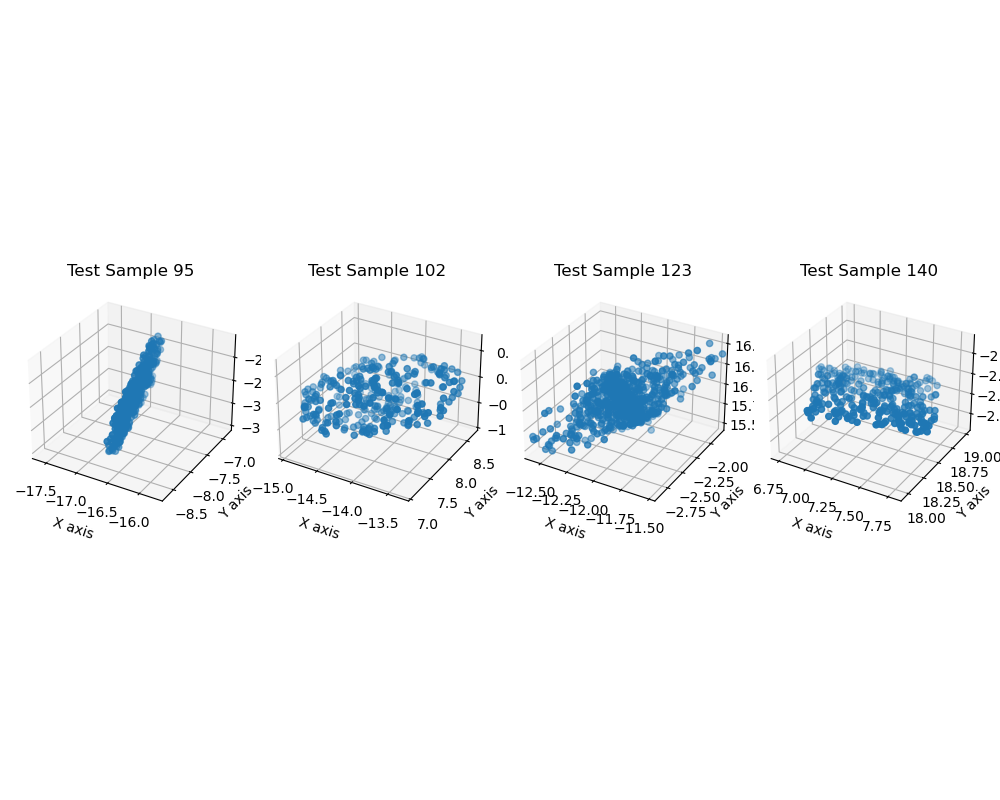

In [46]:
visualize_samples(TR_labels,TR_y_pred,TR_original_shape_data,[95,102,123,140])

## Classification of 4D shapes

For testing our approach in R4 we just need to make a few changes: generate 4-dimensional data and make appropriate changes for our feature-generating functions. For example we have to remove 4dim ball and instead of just calculating homology_dimensions=[0, 1, 2] we have to take [0,1,2,3].

In [47]:
with open('Data/4d_combined3_flattened_data_with_indices.pkl', 'rb') as f_img:
    d4_combined_flattened_data = pickle.load(f_img)

# Extracting indices, combined vectors, and labels
d4_indices, d4_combined_vectors, d4_labels = zip(*d4_combined_flattened_data)

# Convert to numpy arrays
d4_combined_vectors = np.array(d4_combined_vectors)
d4_labels = np.array(d4_labels)

# Load the rotated point clouds for visualization
with open('Shape_data/m_4d_shapes_data.pkl', 'rb') as file:
    d4_original_shape_data = pickle.load(file)

# Extracting indices, combined vectors, and labels
d4_indices2, d4_combined_vectors2, d4_labels2 = zip(*d4_original_shape_data)

In [48]:
# Train-test split with stratification
X4_train, X4_test, y4_train, y4_test, idx4_train, idx4_test = train_test_split(
    d4_combined_vectors, d4_labels, d4_indices, test_size=0.3, random_state=42, stratify=d4_labels
)

In [49]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define the parameter grid: 
param_grid = {
    'C': [0.1, 1, 10, 100, 200],  # Regularization parameter
    'kernel': ['rbf']  # RBF kernel
}

# Initialize the SVM model
svm_model4 = SVC()

# Set up GridSearchCV
grid_search4 = GridSearchCV(svm_model4, param_grid, cv=5, verbose=2, n_jobs=-1)

# Fit grid search to the data
grid_search4.fit(X4_train, y4_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search4.best_params_)
print("Best Score:", grid_search4.best_score_)

# Retrieve the best model
svm_model4 = grid_search4.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[CV] END ...................................C=10, kernel=rbf; total time=   0.5s
[CV] END ...................................C=10, kernel=rbf; total time=   0.8s
[CV] END ....................................C=1, kernel=rbf; total time=   0.9s
[CV] END ....................................C=1, kernel=rbf; total time=   0.9s
[CV] END ....................................C=1, kernel=rbf; total time=   0.9s
[CV] END ...................................C=10, kernel=rbf; total time=   0.5s
[CV] END ....................................C=1, kernel=rbf; total time=   1.2s
[CV] END ....................................C=1, kernel=rbf; total time=   1.3s
[CV] END ..................................C=0.1, kernel=rbf; total time=   1.3s
[CV] END ..................................C=0.1, kernel=rbf; total time=   1.4s
[CV] END ...................................C=10, kernel=rbf; total time=   0.6s
[CV] END ..................................C=100, kernel=rbf; total time=   0.5s
[CV] END ...................

Making and checking predicitions on test set:

In [50]:
# Predict on the test set
y4_pred = svm_model4.predict(X4_test)

# Calculate accuracy
accuracy4 = accuracy_score(y4_test, y4_pred)
print(f"Accuracy: {accuracy4:.2f}\n")


Accuracy: 1.00



In [51]:
label_names_4d = {0: "4d_sphere", 1: "4d_line_segment", 2: "4d_disc", 3:"4d_perturbed_3_disc",4:"4d_ellipsoid"}

def classification_report_4d(y_true, y_predicted):
    from sklearn.metrics import confusion_matrix
    import numpy as np

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_predicted)

    # Calculate and display class-wise accuracy
    for class_index, class_name in label_names_4d.items():
        correct = conf_matrix[class_index, class_index]
        incorrect = sum(conf_matrix[class_index, :]) - correct
        print(f"Class '{class_name}': Correctly classified: {correct}, Incorrectly classified: {incorrect}")

In [52]:
classification_report_4d(y4_test,y4_pred)

Class '4d_sphere': Correctly classified: 6, Incorrectly classified: 0
Class '4d_line_segment': Correctly classified: 6, Incorrectly classified: 0
Class '4d_disc': Correctly classified: 6, Incorrectly classified: 0
Class '4d_perturbed_3_disc': Correctly classified: 6, Incorrectly classified: 0
Class '4d_ellipsoid': Correctly classified: 6, Incorrectly classified: 0


Everything is classified correctly. Now lets check how our model performs on training set.

In [53]:
# Predict on the training set
y4_train_pred = svm_model4.predict(X4_train)

# Calculate accuracy
accuracy4_train = accuracy_score(y4_train, y4_train_pred)
print(f"Accuracy: {accuracy4_train:.2f}\n")

Accuracy: 0.99



In [54]:
classification_report_4d(y4_train,y4_train_pred)

Class '4d_sphere': Correctly classified: 14, Incorrectly classified: 0
Class '4d_line_segment': Correctly classified: 14, Incorrectly classified: 0
Class '4d_disc': Correctly classified: 13, Incorrectly classified: 1
Class '4d_perturbed_3_disc': Correctly classified: 14, Incorrectly classified: 0
Class '4d_ellipsoid': Correctly classified: 14, Incorrectly classified: 0


In [55]:
def analyze_misclassifications_4d(y_true, y_pred, label_names):
    misclassified = []

    for i in range(len(y_true)):
        if y_true[i] != y_pred[i]:
            original_class = label_names.get(y_true[i], "Unknown")
            predicted_class = label_names.get(y_pred[i], "Unknown")
            misclassified.append((i, original_class, predicted_class))

    return misclassified

In [56]:
d4_misclassifications=analyze_misclassifications_4d(y4_train,y4_train_pred, label_names_4d)

print("Misclassified Shapes in Training Set:")
for index, original_class, predicted_class in d4_misclassifications:
    print(f"Index: {index}, Original Class: {original_class}, Predicted Class: {predicted_class}")

Misclassified Shapes in Training Set:
Index: 3, Original Class: 4d_disc, Predicted Class: 4d_ellipsoid


We only misclassified one shape. Our approach seems to be working in 4d as well. (Note that for 4D we only generated 5 different classes)

## Classification of more complex versions

Lastly we want to check how our model (and our preprocessing) works on a bit more complex instances of our original 8 distinct shapes. We generated rotated and translated pointclouds that vary in size from the original pointclouds (for example radius/length 20 times as big).

In [57]:
with open('Data/random_combined3_flattened_data_with_indices.pkl', 'rb') as f_img:
    random_combined_flattened_data = pickle.load(f_img)

# Extracting indices, combined vectors, and labels
random_indices, random_combined_vectors, random_labels = zip(*random_combined_flattened_data)

# Convert to numpy arrays
random_combined_vectors = np.array(random_combined_vectors)
random_labels = np.array(random_labels)

# Load the rotated point clouds for visualization
with open('Shape_data/m_random_shapes_data.pkl', 'rb') as file:
    random_original_shape_data = pickle.load(file)

# Extracting indices, combined vectors, and labels
random_indices2, random_combined_vectors2, random_labels2 = zip(*random_original_shape_data)

In [58]:
random_y_pred = svm_model.predict(random_combined_vectors)

# Calculate accuracy
random_accuracy = accuracy_score(random_labels, random_y_pred)
print(f"Accuracy: {random_accuracy:.2f}")

Accuracy: 0.84


In [59]:
classification_report(random_labels,random_y_pred)

Class 'sphere': Correctly classified: 20, Incorrectly classified: 0
Class 'circle': Correctly classified: 20, Incorrectly classified: 0
Class 'line_segment': Correctly classified: 18, Incorrectly classified: 2
Class 'torus': Correctly classified: 20, Incorrectly classified: 0
Class 'flat_disc': Correctly classified: 20, Incorrectly classified: 0
Class 'ellipsoid': Correctly classified: 13, Incorrectly classified: 7
Class 'perturbed_3_disc': Correctly classified: 14, Incorrectly classified: 6
Class 'rectangle': Correctly classified: 10, Incorrectly classified: 10


In [60]:
# Analyze misclassifications on the training set
random_misclassifications = analyze_misclassifications(random_labels, random_y_pred, label_names)#,TR_indices)

# Print the misclassifications
print("Misclassified Shapes in Training Set:")
for index, original_class, predicted_class in random_misclassifications:
    print(f"Index: {index}, Original Class: {original_class}, Predicted Class: {predicted_class}")

Misclassified Shapes in Training Set:
Index: 41, Original Class: line_segment, Predicted Class: circle
Index: 51, Original Class: line_segment, Predicted Class: circle
Index: 101, Original Class: ellipsoid, Predicted Class: circle
Index: 102, Original Class: ellipsoid, Predicted Class: torus
Index: 103, Original Class: ellipsoid, Predicted Class: sphere
Index: 109, Original Class: ellipsoid, Predicted Class: circle
Index: 110, Original Class: ellipsoid, Predicted Class: sphere
Index: 113, Original Class: ellipsoid, Predicted Class: circle
Index: 115, Original Class: ellipsoid, Predicted Class: torus
Index: 120, Original Class: perturbed_3_disc, Predicted Class: flat_disc
Index: 123, Original Class: perturbed_3_disc, Predicted Class: flat_disc
Index: 127, Original Class: perturbed_3_disc, Predicted Class: flat_disc
Index: 131, Original Class: perturbed_3_disc, Predicted Class: flat_disc
Index: 132, Original Class: perturbed_3_disc, Predicted Class: ellipsoid
Index: 137, Original Class: 

Now lets visualize some shapes that are causing the trouble.

Test Sample 101 - Predicted Class: circle, Actual Class: ellipsoid
Test Sample 137 - Predicted Class: flat_disc, Actual Class: perturbed_3_disc
Test Sample 110 - Predicted Class: sphere, Actual Class: ellipsoid
Test Sample 158 - Predicted Class: flat_disc, Actual Class: rectangle


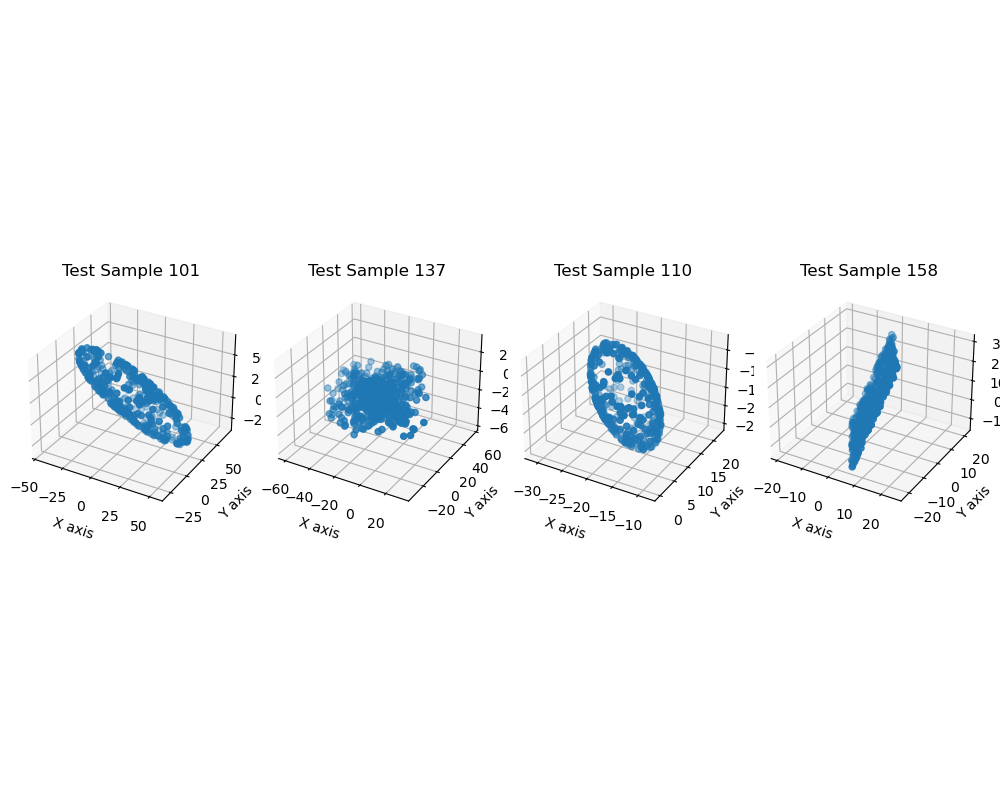

In [61]:
visualize_samples(random_labels,random_y_pred,random_original_shape_data,[101,137,110,158])

We can see that shape 101 is a very thin and big elipsoid. When we squeeze it when doing standardization it looks quite like a circle, so that may be a reason for misclassification. Similar goes for other shapes, for example ellipsoid 110 is of a simmilar dimensions as a sphere and when we squeeze it appears even more like sphere. So one possible improvement of our model would be a standardization method that solves this problem.